In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import pandas as pd
from train_utils import train_model, BCLogitMetric

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

In [3]:
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, uncertainty_avg, score_avg

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
np.random.seed(1234)
torch.manual_seed(1234)

In [6]:
training_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Training.data", sep=',', dtype=np.float32)
testing_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Testing.data", sep=',', dtype=np.float32)

In [7]:
dim = 1
seq_length = 100

In [8]:
x_train = minmax_scale(training_table.drop("class", axis=1).values, axis=1)
y_train = training_table["class"].values
x_test = minmax_scale(testing_table.drop("class", axis=1).values, axis=1)
y_test = testing_table["class"].values

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

N = len(y_train)

train_dl = torch.utils.data.DataLoader(
        [(x_train[i], y_train[i]) for i in range(len(y_train))],
        batch_size=10,
        shuffle=True
)
val_dl = torch.utils.data.DataLoader(
        [(x_val[i], y_val[i]) for i in range(len(y_val))],
        batch_size=10,
        shuffle=False
)
test_dl = torch.utils.data.DataLoader(
        [(x_test[i], y_test[i]) for i in range(len(y_test))],
        batch_size=len(y_test),
        shuffle=False
)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(1, 10)
        self.fc = nn.Linear(10, 1)

    def regularizer(self):        
        return 0.

    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = out[-1]
        out = torch.tanh(out)
        out = self.fc(out).flatten()
        return out

In [11]:
net = Net()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [12]:
metrics = [BCLogitMetric()]

In [13]:
%%time
net = train_model(net, train_dl, val_dl, criterion, optimizer, "hill-valley.pt", 100, metrics=metrics, patience=5)

[1, 100.00%] train loss: 0.690908
[1, 100.00%] validate loss: 0.707452
Accuracy = 0.484
[2, 100.00%] train loss: 0.652070
[2, 100.00%] validate loss: 0.604945
Accuracy = 0.734
[3, 100.00%] train loss: 0.424376
[3, 100.00%] validate loss: 0.318744
Accuracy = 0.819
[4, 100.00%] train loss: 0.248940
[4, 100.00%] validate loss: 0.213370
Accuracy = 0.863
[5, 100.00%] train loss: 0.180113
[5, 100.00%] validate loss: 0.162859
Accuracy = 0.889
[6, 100.00%] train loss: 0.136903
[6, 100.00%] validate loss: 0.129599
Accuracy = 0.907
[7, 100.00%] train loss: 0.110550
[7, 100.00%] validate loss: 0.106442
Accuracy = 0.919
[8, 100.00%] train loss: 0.091940
[8, 100.00%] validate loss: 0.090188
Accuracy = 0.929
[9, 100.00%] train loss: 0.078840
[9, 100.00%] validate loss: 0.078577
Accuracy = 0.936
[10, 100.00%] train loss: 0.069492
[10, 100.00%] validate loss: 0.054545
Accuracy = 0.942
[11, 100.00%] train loss: 0.062134
[11, 100.00%] validate loss: 0.046898
Accuracy = 0.948
[12, 100.00%] train loss: 0.

### Test

In [14]:
net.eval()
acc = 0.0
with torch.no_grad():
    for i, (x, y) in enumerate(test_dl):
        pre_sigmoids = net(x.transpose(-2,-3))
        post_sigmoids = torch.sigmoid(pre_sigmoids)
        scores = post_sigmoids
        predictions = torch.round(scores)
        acc += (y == predictions).sum().item()

acc /= len(test_dl.dataset)
print("Accuracy = %.2f%%" % (acc * 100))

Accuracy = 100.00%


### Flat line test

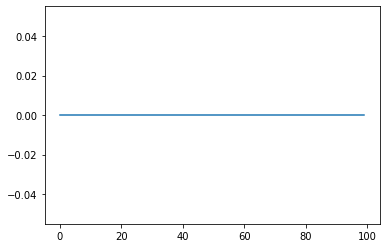

predictions tensor([0.9953, 0.9953])


In [15]:
new_x_test = minmax_scale(np.full((2, 100), 0., dtype=np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

net.eval()
with torch.no_grad():
    outputs = net(new_x_test)
    outputs = torch.sigmoid(outputs)
    scores = outputs

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", scores)

### Noise test

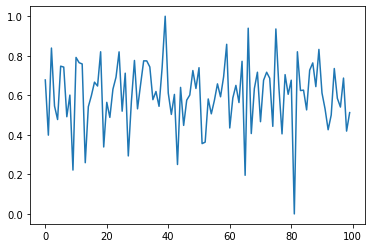

predictions tensor([0.0024, 0.0026])


In [17]:
new_x_test = minmax_scale(np.random.randn(2, 100).astype(np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

net.eval()
with torch.no_grad():
    outputs = net(new_x_test)
    outputs = torch.sigmoid(outputs)
    scores = outputs

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", scores)